In [8]:
import os, sys
sys.path.append("../third_party/LightSB")
sys.path.append("../third_party/LightSB/ALAE")

from matplotlib import pyplot as plt
import time
from sklearn.mixture import GaussianMixture
from src.my_utils import *
from tqdm import tqdm
import torchsde
from src import GMMflow, load_latents
from alae_ffhq_inference import load_model, encode, decode

########### #for newer versions of pytorch this is needed to load model checkpoints.
import tracker
torch.serialization.add_safe_globals([tracker.RunningMeanTorch])
#############

In [3]:
# # To download ALAE data use
#
# import gdown
# import os
#
# urls = {
#     "../third_party/LightSB/data/age.npy": "https://drive.google.com/uc?id=1Vi6NzxCsS23GBNq48E-97Z9UuIuNaxPJ",
#     "../third_party/LightSB/data/gender.npy": "https://drive.google.com/uc?id=1SEdsmQGL3mOok1CPTBEfc_O1750fGRtf",
#     "../third_party/LightSB/data/latents.npy": "https://drive.google.com/uc?id=1ENhiTRsHtSjIjoRu1xYprcpNd8M9aVu8",
#     "../third_party/LightSB/data/test_images.npy": "https://drive.google.com/uc?id=1SjBWWlPjq-dxX4kxzW-Zn3iUR3po8Z0i",
# }
#
# for name, url in urls.items():
#     gdown.download(url, os.path.join(f"{name}"), quiet=False)

## Configuration

In [10]:
initial = "MAN" # MAN, WOMAN, ADULT, CHILDREN
translated = "WOMAN" # MAN, WOMAN, ADULT, CHILDREN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 13
DIM = 512
epsilon = 0.01
N0 = 10 # initial GMM components
N1 = 10 # final GMM components

X_train, X_test, Y_train, Y_test = load_latents(initial, translated, train_test_ratio=0.6)  # we need ~10K test data to compute accurate FID.
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_test, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
Y_test = torch.tensor(Y_test, dtype=torch.float32, device=device)

## Fit GMMs to the latents

In [11]:
start = time.time()

gmm0 = GaussianMixture(n_components=10, covariance_type='diag', random_state=0).fit(X_train.cpu().numpy())
gmm1 = GaussianMixture(n_components=10,  covariance_type='diag', random_state=0).fit(Y_train.cpu().numpy())
Mu0 = torch.tensor(gmm0.means_, dtype = torch.float32, device=device)
Sigma0 = torch.tensor(gmm0.covariances_, dtype = torch.float32, device=device)
Mu1 = torch.tensor(gmm1.means_, dtype = torch.float32, device=device)
Sigma1 = torch.tensor(gmm1.covariances_, dtype = torch.float32, device=device)

W0 = torch.tensor(gmm0.weights_, dtype = torch.float32, device=device)
W1 = torch.tensor(gmm1.weights_, dtype = torch.float32, device=device)

#define the sde
sde = GMMflow(Mu0, Mu1, Sigma0, Sigma1, W0, W1, epsilon=np.sqrt(epsilon), device = device)

end = time.time()
print("Training time: ", end-start)

Training time:  4.182761192321777


## Transform the samples

In [12]:
torch.cuda.empty_cache()
number_of_samples = 4 # number of samples for each image (for epsilon > 0)
y0 = X_test[0:10,:].to(device).unsqueeze(0).repeat(number_of_samples, 1, 1).reshape(-1, DIM)
t = torch.linspace(0, 1., 2, device=device)

with torch.no_grad():
    yf = []
    for y0_batch in tqdm(torch.split(y0, 1000, dim=0)):
        torch.cuda.empty_cache()
        y = torchsde.sdeint(sde, y0_batch, t, method='euler', dt=0.005) # y will be of size (t_size, batch_size, state_size)
        yf.append(y[-1, :, :].reshape(number_of_samples, -1, DIM))
        
# YF = torch.cat(yf, dim=1)[0]

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


In [13]:
# Decode the translated latent samples
# To download the required model run training_artifacts/download_all.py in the third_part/LightSB/ALAE folder.

model = load_model("../third_party/LightSB/ALAE/configs/ffhq.yaml", training_artifacts_dir="../third_party/LightSB/ALAE/training_artifacts/ffhq/")
model = model.to(device)
torch.cuda.empty_cache()
yf = y[-1, :, :].reshape(number_of_samples, -1, DIM)

In [14]:
decoded_all_translated = []
with torch.no_grad():
    for k in range(number_of_samples):
        decoded_img = decode(model, yf[k, :].cuda())
        decoded_img = ((decoded_img * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).permute(0, 2, 3, 1).numpy()
        decoded_all_translated.append(decoded_img)
        
decoded_all_translated = np.stack(decoded_all_translated, axis=1)

In [15]:
decoded_all_initial = []
with torch.no_grad():
    decoded_img = decode(model, X_test[0:10,:])
    decoded_img = ((decoded_img * 0.5 + 0.5) * 255).type(torch.long).clamp(0, 255).cpu().type(torch.uint8).permute(0, 2, 3, 1).numpy()
    decoded_all_initial.append(decoded_img)

decoded_all_initial = np.concat(decoded_all_initial, axis=0)

Text(0.67, 1.01, 'Go With the Flow')

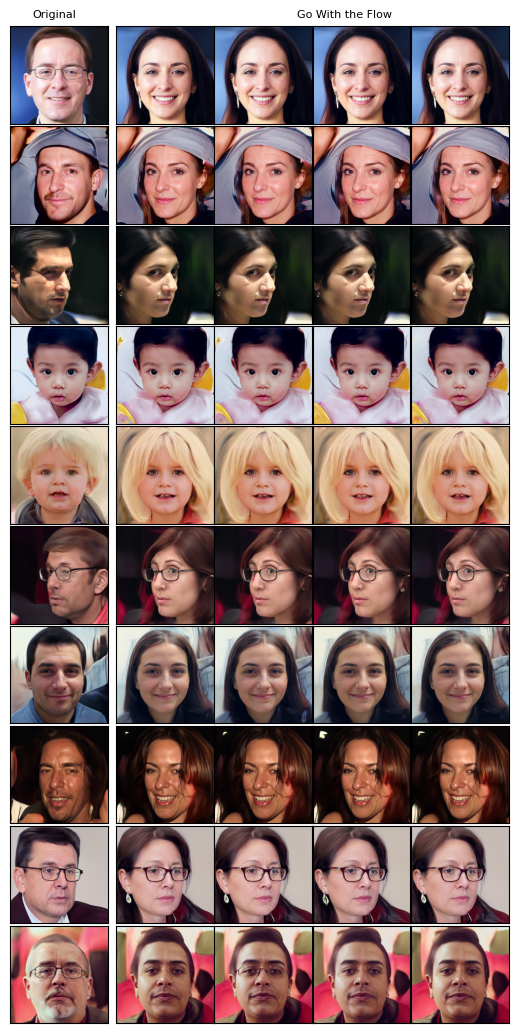

In [16]:
%matplotlib inline

inp_images = X_test[0:10,:]
fig, axes = plt.subplots(nrows=10, 
                         ncols=number_of_samples + 2, 
                         figsize=(number_of_samples + 1, 10), 
                         dpi=100,
                         gridspec_kw={'width_ratios': [0.7, 0.05, 0.7, 0.7, 0.7, 0.7]} )

for i, ind in enumerate(range(10)):
    ax = axes[i]
    ax[0].imshow(decoded_all_initial[ind])
    ax[1].axis('off')

    for k in range(4):
  
        ax[k + 2].imshow(decoded_all_translated[ind, k])
        ax[k + 2].get_xaxis().set_visible(False)
        ax[k + 2].set_yticks([])

    ax[0].get_xaxis().set_visible(False)
    ax[0].set_yticks([])

fig.tight_layout(pad=0.05)
plt.figtext(0.09, 1.01, 'Original', va="center", ha="center", size=8)
plt.figtext(0.67, 1.01, 'Go With the Flow', va="center", ha="center", size=8)